<a href="https://colab.research.google.com/github/marco-luzzara/boardgame-complexity-predictor/blob/master/src/predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
WORKING_LOCALLY = bool(os.getenv('WORKING_LOCALLY'))

PROCESSED_DATASET_FILE_PATH = 'data/processed_dataset.csv' if WORKING_LOCALLY \
    else '/content/drive/My Drive/Projects/IRBoardGameComplexity/processed_dataset.csv'

if not WORKING_LOCALLY:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install -U scikit-learn

df_features = pd.read_csv(PROCESSED_DATASET_FILE_PATH)
x_all, y_all = df_features.iloc[:, 1:], df_features.iloc[:, 0]
df_features.head()

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.7 MB 13.9 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


,averageweight,playingtime,rulebook_len,dice_luck_metric,drawing_luck_metric,shuffling_luck_metric,random_luck_metric,can_metric,choices_metric,entities_count,...,entities_variance,abstracts,cgs,childrensgames,familygames,partygames,strategygames,thematic,unspecified,wargames
0,2.1579,60,3155.0,0.0,0.000000,0.147710,0.000000,0.590842,0.295421,5.0,...,2.439704,0,0,0,1,0,0,0,0,0
1,3.1452,90,73093.0,0.0,0.013557,0.027113,0.027113,1.342100,0.135566,62.0,...,47.504669,0,0,0,0,0,1,0,0,0
2,1.8100,90,20155.0,0.0,0.000000,0.000000,0.000000,0.911927,0.143988,39.0,...,13.679672,0,0,0,0,0,0,1,0,0
3,1.4858,30,13866.0,0.0,0.413936,0.137979,0.000000,0.551914,0.275957,14.0,...,9.450702,0,0,0,1,0,0,0,0,0
4,2.7813,120,3604.0,0.0,0.000000,0.000000,0.000000,0.583090,1.020408,8.0,...,1.764098,0,0,0,0,0,1,0,0,0


In [39]:
import logging

logger = logging.getLogger('bgg_predict')
logger.handlers.clear()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

In [2]:
from collections import namedtuple
from typing import Generator, Tuple, List
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from tempfile import mkdtemp

FeaturesWithPrediction = namedtuple('FeaturesWithPrediction', ['y', 'x'])
SplitDataset = namedtuple('SplitDataset', ['train', 'test'])

def custom_cv_stratified_regression(fold_count: int, 
                                    x, y, 
                                    train_size = None, test_size = None,
                                    random_state = None) -> Generator[Tuple[List[int], List[int]], None, None]:
    splitter = StratifiedShuffleSplit(n_splits=fold_count, 
                                      train_size = train_size, test_size = test_size,
                                      random_state = random_state)
    # avg * 2 gives at most 10 classes
    weights_categories = y.squeeze().apply(lambda avg: round(avg * 2))
    for train_indices, test_indices in splitter.split(x, weights_categories):
        yield train_indices, test_indices

def train_test_stratified_split(x, y, 
                                train_size = None, test_size = None,
                                random_state = None):
    splitter = custom_cv_stratified_regression(1, x, y, 
                                               train_size, test_size, random_state = random_state)
    train_indices, test_indices = next(splitter)
    return x.iloc[train_indices], x.iloc[test_indices],\
           y.iloc[train_indices], y.iloc[test_indices]

estimator_cachedir = mkdtemp()
class Model:
    def __get_class_name(self, component):
        cls_name = component.__class__.__name__
        if cls_name == 'ColumnTransformer':
            cls_name = ' + '.join(trf[1].__class__.__name__ for trf in component.transformers)

        return cls_name

    def __init__(self, components, params_tuning = None):
        self.name = ' + '.join(self.__get_class_name(component[1]) for component in components)
        self.instance = Pipeline(components, memory = estimator_cachedir)
        self.params_tuning = params_tuning

In [23]:
import math
import matplotlib.pyplot as plt
import ipywidgets as widgets
from typing import List
from sklearn.metrics import PredictionErrorDisplay

MAX_PLOT_IN_ROW = 3
PLOT_INCHES = 6

def fill_predictions_subplot(ax, i_model: int, title: str, y_test, y_predictions) -> None:
    row = i_model // MAX_PLOT_IN_ROW
    col = i_model % MAX_PLOT_IN_ROW

    subplot = ax[row][col]
    subplot.grid(True)
    PredictionErrorDisplay.from_predictions(
        y_true=y_test,
        y_pred=y_predictions,
        kind="actual_vs_predicted",
        ax=subplot,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )
    subplot.set_title(title)

def create_containing_plot(plot_id: int, subplots_count):
    containing_plot_rows = math.ceil(subplots_count / MAX_PLOT_IN_ROW)
    containing_plot_height = containing_plot_rows * PLOT_INCHES
    fig, ax = plt.subplots(nrows=containing_plot_rows, ncols=MAX_PLOT_IN_ROW, squeeze=False,
                           figsize=(MAX_PLOT_IN_ROW * PLOT_INCHES, containing_plot_rows * PLOT_INCHES), 
                           num=plot_id)
    for i in range(containing_plot_rows * MAX_PLOT_IN_ROW - subplots_count):
        fig.delaxes(ax[-1][MAX_PLOT_IN_ROW - i - 1])
    
    return fig, ax

def create_header(text: str):
    display(widgets.HTML(
        value=f"<h1>{text}</h1>"
    ))

In [32]:
from collections import namedtuple
from typing import Tuple, Any, Dict
import numpy as np
from sklearn.model_selection import cross_validate, GridSearchCV

PerformanceMetrics = namedtuple('PerformanceMetrics', ['r2', 'mae', 'mape', 'mse'])

# TODO: make cv_scoring assignment dynamic in performance metrics
def get_fit_estimator(estimator, x_train, y_train, splitter, cv_scorings) \
        -> Tuple[Any, PerformanceMetrics, Dict]:
    cv_results = cross_validate(estimator, 
                                x_train, y_train,
                                cv = splitter,
                                scoring = cv_scorings)
    estimator.fit(x_train, y_train)

    r2 = np.mean(cv_results['test_r2'])
    mae = np.mean(cv_results['test_neg_mean_absolute_error'])
    mape = np.mean(cv_results['test_neg_mean_absolute_percentage_error'])
    mse = np.mean(cv_results['test_neg_mean_squared_error'])
    performanceMetrics = PerformanceMetrics(r2, mae, mape, mse)

    return estimator, performanceMetrics, None

def get_fit_estimator_with_tuning(estimator, params, x_train, y_train, \
                                  splitter, cv_scorings) -> Tuple[Any, PerformanceMetrics, Dict]:
    # refit needs an existing scoring
    assert 'neg_mean_absolute_error' in cv_scorings
    search = GridSearchCV(estimator,
                          params,
                          cv = splitter,
                          refit = 'neg_mean_absolute_error',
                          n_jobs = -1, 
                          scoring = cv_scorings,
                          return_train_score = True)
            
    search.fit(x_train, y_train)
    estimator = search.best_estimator_

    r2, mae, mape, mse = search.cv_results_['mean_test_r2'][search.best_index_], \
                         search.cv_results_['mean_test_neg_mean_absolute_error'][search.best_index_], \
                         search.cv_results_['mean_test_neg_mean_absolute_percentage_error'][search.best_index_], \
                         search.cv_results_['mean_test_neg_mean_squared_error'][search.best_index_]
    performanceMetrics = PerformanceMetrics(r2, mae, mape, mse)

    return estimator, performanceMetrics, search.best_params_

# Preprocessing

In [43]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer, MaxAbsScaler
from sklearn.compose import ColumnTransformer
from typing import List, Tuple, Any

def build_column_transformer(*transformers: Tuple[Any, List[str]]):
    return ColumnTransformer([(f'trf{i}', *trf) for i, trf in enumerate(transformers)], \
                             remainder='passthrough')

features_to_scale = ['playingtime', 'rulebook_len', 'dice_luck_metric',
    'drawing_luck_metric', 'shuffling_luck_metric', 'random_luck_metric',
    'can_metric', 'choices_metric', 'entities_count', 'interaction_score',
    'entities_variance']

trf_minmax = build_column_transformer((MinMaxScaler(), features_to_scale))
trf_maxabs = build_column_transformer((MaxAbsScaler(), features_to_scale))
trf_robust = build_column_transformer((RobustScaler(), features_to_scale))
# trf_quantile_uniform = build_column_transformer((QuantileTransformer(), features_to_scale))
# trf_quantile_normal = build_column_transformer((QuantileTransformer(output_distribution='normal'), features_to_scale))
trf_standard = build_column_transformer((StandardScaler(), features_to_scale))
trf_none = None

trf = trf_minmax
trfs = [trf_minmax, trf_maxabs, trf_robust, trf_standard]#, trf_none]

build_column_transformer((trf, features_to_scale))

ColumnTransformer(remainder='passthrough',
                  transformers=[('trf0',
                                 ColumnTransformer(remainder='passthrough',
                                                   transformers=[('trf0',
                                                                  MinMaxScaler(),
                                                                  ['playingtime',
                                                                   'rulebook_len',
                                                                   'dice_luck_metric',
                                                                   'drawing_luck_metric',
                                                                   'shuffling_luck_metric',
                                                                   'random_luck_metric',
                                                                   'can_metric',
                                                                   'choices_metric',
                                                                   'entities_count',
                                                                   'interaction_score',
                                                                   'entities_variance'])]),
                                 ['playingtime', 'rulebook_len',
                                  'dice_luck_metric', 'drawing_luck_metric',
                                  'shuffling_luck_metric', 'random_luck_metric',
                                  'can_metric', 'choices_metric',
                                  'entities_count', 'interaction_score',
                                  'entities_variance'])])

# Feature Selection

In [18]:
from sklearn.feature_selection import SelectKBest, RFECV, SelectFromModel
from sklearn.feature_selection import r_regression, f_regression, mutual_info_regression
from sklearn.linear_model import LassoCV
from sklearn.model_selection import ShuffleSplit

# for score_fun in [r_regression, f_regression, mutual_info_regression]:
#     for k in range(5, len(x_all.columns) + 1):
#         x_new = SelectKBest(score_fun, k = k).fit_transform(x_all, y_all)

# only for coefficients-based models
def build_estimator_with_rfecv(estimator):
    return RFECV(
        estimator=estimator,
        step=1,
        cv=ShuffleSplit(5, test_size = 0.2, random_state = 0),
        scoring="r2",
        min_features_to_select=5,
        n_jobs=-1
    )

select_from_model = SelectFromModel(LassoCV())
kbest = SelectKBest(mutual_info_regression)

selectors = [select_from_model, kbest]

# Models

In [57]:
from sklearn import linear_model, svm, kernel_ridge, neighbors, tree
from typing import Dict, List, Any
from scipy import stats

def build_model_variances(scalers, feature_selectors, estimator, params: Dict[str, List[Any]] = None) -> List[Model]:
    return [Model([('scaler', scaler), 
                   ('feature_selector', selector),
                   ('estimator', estimator)
                   ], params) \
        for scaler in (scalers or [None]) \
        for selector in (feature_selectors or [None])]
            


models: Dict[str, List[Model]] = {
    #'Linear Models': [
        # *build_model_variances(trfs, [], build_estimator_with_rfecv(linear_model.LinearRegression())),
        # *[Model([('scaler', t), ('estimator', linear_model.LassoCV())]) for t in trfs], # robust
        # *[Model([('scaler', t), ('estimator', linear_model.LassoLarsCV())]) for t in trfs],
        # Model([('scaler', trf), ('estimator', linear_model.ElasticNetCV())]),
        # Model([('scaler', trf), ('estimator', linear_model.RidgeCV())]),
        # Model([('scaler', trf), ('estimator', linear_model.OrthogonalMatchingPursuitCV())]),
        # Model([('scaler', trf), ('estimator', linear_model.BayesianRidge())], {
        #     'estimator__alpha_1': stats.gamma.rvs(1, size = 5), 'estimator__alpha_2': stats.gamma.rvs(1, size = 5), 
        #     'estimator__lambda_1': stats.gamma.rvs(1, size = 5), 'estimator__lambda_2': stats.gamma.rvs(1, size = 5), 
        # }),
        # Model([('scaler', trf), ('estimator', linear_model.ARDRegression())], {
        #     'estimator__alpha_1': stats.gamma.rvs(1, size = 5), 'estimator__alpha_2': stats.gamma.rvs(1, size = 5), 
        #     'estimator__lambda_1': stats.gamma.rvs(1, size = 5), 'estimator__lambda_2': stats.gamma.rvs(1, size = 5), 
        # }),
        # Model([('scaler', trf), ('estimator', linear_model.PoissonRegressor())], {
        #     'estimator__alpha': [1, 10, 50, 100, 1000], 'estimator__solver': ['lbfgs', 'newton-cholesky']
        # }),
        # Model([('scaler', trf), ('estimator', linear_model.GammaRegressor())], {
        #     'estimator__alpha': [1, 10, 50, 100, 1000], 'estimator__solver': ['lbfgs', 'newton-cholesky']
        # }),
        # Model([('scaler', trf), ('estimator', linear_model.PassiveAggressiveRegressor())], {
        #     'estimator__C': [1, 2, 3], 'estimator__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
        # }),
        # # L2-regularized linear regression model that is robust to outliers.
        # Model([('scaler', trf), ('estimator', linear_model.HuberRegressor())], {
        #     'estimator__epsilon': [1, 1.35, 1.5, 2], 'estimator__alpha': [0.00005, 0.0001, 0.0005]
        # }),
        # Model([('scaler', trf), ('estimator', linear_model.QuantileRegressor())], {
        #     'estimator__quantile': [0.15, 0.30, 0.5, 0.7, 0.85], 'estimator__alpha': [0.5, 1, 1.5, 2],
        #     'estimator__solver': ['highs-ds', 'highs-ipm', 'highs', 'interior-point', 'revised simplex']
        # }),
    #],
    # 'Support Vector Machines': [
    #     *build_model_variances(trfs, [select_from_model], svm.SVR(), {
    #         'estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    #     }),
    #     *build_model_variances(trfs, [kbest], svm.SVR(), {
    #         'estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    #         'feature_selector__k': [5, 7, 10, 12, 15]
    #     }),
    # ],
    'Nearest Neighbors': [
        *build_model_variances(trfs, [select_from_model], neighbors.KNeighborsRegressor(), {
            'estimator__n_neighbors': [3,4,5,6,7], 'estimator__weights': ['uniform', 'distance'], 
        }),
        *build_model_variances(trfs, [select_from_model], neighbors.RadiusNeighborsRegressor(), {
            'estimator__radius': [1, 2, 5, 10], 'estimator__weights': ['uniform', 'distance'],
        }),
        *build_model_variances(trfs, [kbest], neighbors.KNeighborsRegressor(), {
            'estimator__n_neighbors': [3,4,5,6,7], 'estimator__weights': ['uniform', 'distance'], 
            'feature_selector__k': [_ for _ in range(5, 16)]
        }),
        *build_model_variances(trfs, [kbest], neighbors.RadiusNeighborsRegressor(), {
            'estimator__radius': [1, 2, 5, 10], 'estimator__weights': ['uniform', 'distance'],
            'feature_selector__k': [_ for _ in range(5, 16)]
        }),
    ],
    # # TODO: see ensemble methods
    # 'Decision Tree': [
    #     Model(tree.DecisionTreeRegressor()),
    #     Model(tree.ExtraTreeRegressor()),
    # ]
}

# Models Evaluation

## Validation Curve for Hyper Params

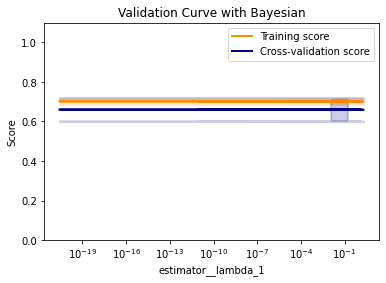

In [ ]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import numpy as np

model = models['Linear Models'][8].instance
param = 'estimator__lambda_1'

# copied from https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
param_range = stats.gamma.rvs(0.1, size = 50)
train_scores, test_scores = validation_curve(model,
    x_all,
    y_all,
    param_name=param,
    param_range=param_range,
    scoring="r2",
    n_jobs=2,
    cv = custom_cv_stratified_regression(5, x_all, y_all, test_size = 0.20, random_state = 0))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Bayesian")
plt.xlabel(param)
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

## Learning Curve

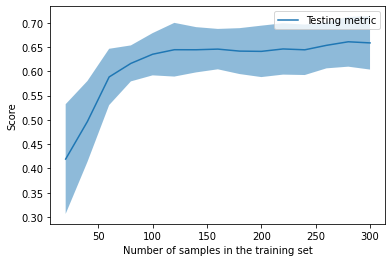

In [ ]:
from sklearn.model_selection import LearningCurveDisplay

model = models['Linear Models'][8].instance

LearningCurveDisplay.from_estimator(
   model, x_all, y_all, train_sizes=list(range(20, int(len(x_all) * 0.8), 20)),
   scoring = 'r2',
   cv=custom_cv_stratified_regression(5, x_all, y_all, test_size = 0.20, random_state = 0))

## Partial Dependency 

In [ ]:
# import numpy as np
# from sklearn.inspection import PartialDependenceDisplay

# model = models['Linear Models'][4].instance
# model.fit(x_all, y_all)

# columns_count = len(x_all.columns)
# fig, ax = create_containing_plot(0, columns_count)
# flatten_ax = np.matrix.flatten(ax)

# PartialDependenceDisplay.from_estimator(model, x_all, ['rulebook_len', 'can_metric'])
# # for i, column in enumerate(x_all.columns):
# #     PartialDependenceDisplay.from_estimator(model, x_all, [column], 
# #                                             ax=flatten_ax[i], line_kw={"color": "red"})

## Permutation Importance
The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled

In [ ]:
from sklearn.inspection import permutation_importance

model = models['Linear Models'][8].instance
model.fit(x_all, y_all)

r = permutation_importance(model, x_all, y_all, n_repeats=30, random_state=1)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{x_all.columns[i]:<20}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

playingtime         0.305 +/- 0.028
familygames         0.155 +/- 0.017
entities_count      0.146 +/- 0.020
strategygames       0.136 +/- 0.015
unspecified         0.059 +/- 0.009
partygames          0.056 +/- 0.007
childrensgames      0.016 +/- 0.005
rulebook_len        0.016 +/- 0.006
drawing_luck_metric 0.013 +/- 0.004
dice_luck_metric    0.009 +/- 0.004
random_luck_metric  0.008 +/- 0.004


# Predicting

2023-01-01 23:26:10,215 bgg_predict  INFO     Processing model MinMaxScaler + SelectFromModel + KNeighborsRegressor ...
INFO:bgg_predict:Processing model MinMaxScaler + SelectFromModel + KNeighborsRegressor ...
2023-01-01 23:26:11,047 bgg_predict  INFO     model MinMaxScaler + SelectFromModel + KNeighborsRegressor is ready
INFO:bgg_predict:model MinMaxScaler + SelectFromModel + KNeighborsRegressor is ready
2023-01-01 23:26:11,072 bgg_predict  INFO     Processing model MaxAbsScaler + SelectFromModel + KNeighborsRegressor ...
INFO:bgg_predict:Processing model MaxAbsScaler + SelectFromModel + KNeighborsRegressor ...
2023-01-01 23:26:11,866 bgg_predict  INFO     model MaxAbsScaler + SelectFromModel + KNeighborsRegressor is ready
INFO:bgg_predict:model MaxAbsScaler + SelectFromModel + KNeighborsRegressor is ready
2023-01-01 23:26:11,890 bgg_predict  INFO     Processing model RobustScaler + SelectFromModel + KNeighborsRegressor ...
INFO:bgg_predict:Processing model RobustScaler + SelectFromM

,Model,R2,MAE,MAPE,MSE,params
0,StandardScaler + SelectKBest + KNeighborsRegre...,0.636721,-0.355135,-0.165564,-0.217241,"{'estimator__n_neighbors': 6, 'estimator__weig..."
0,RobustScaler + SelectKBest + KNeighborsRegressor,0.623357,-0.357115,-0.165401,-0.224973,"{'estimator__n_neighbors': 5, 'estimator__weig..."
0,MinMaxScaler + SelectKBest + KNeighborsRegressor,0.642442,-0.358766,-0.169923,-0.213979,"{'estimator__n_neighbors': 7, 'estimator__weig..."
0,MaxAbsScaler + SelectKBest + KNeighborsRegressor,0.642124,-0.359163,-0.170110,-0.214167,"{'estimator__n_neighbors': 7, 'estimator__weig..."
0,MaxAbsScaler + SelectFromModel + KNeighborsReg...,0.559356,-0.395669,-0.187401,-0.262621,"{'estimator__n_neighbors': 7, 'estimator__weig..."
0,MinMaxScaler + SelectFromModel + KNeighborsReg...,0.555744,-0.397834,-0.188262,-0.264572,"{'estimator__n_neighbors': 7, 'estimator__weig..."
0,RobustScaler + SelectFromModel + KNeighborsReg...,0.497217,-0.414155,-0.194126,-0.300048,"{'estimator__n_neighbors': 4, 'estimator__weig..."
0,StandardScaler + SelectFromModel + KNeighborsR...,0.463370,-0.420652,-0.194888,-0.320131,"{'estimator__n_neighbors': 3, 'estimator__weig..."
0,MinMaxScaler + SelectKBest + RadiusNeighborsRe...,0.449722,-0.431221,-0.198507,-0.327828,"{'estimator__radius': 1, 'estimator__weights':..."
0,MaxAbsScaler + SelectKBest + RadiusNeighborsRe...,0.449448,-0.431544,-0.198655,-0.327990,"{'estimator__radius': 1, 'estimator__weights':..."


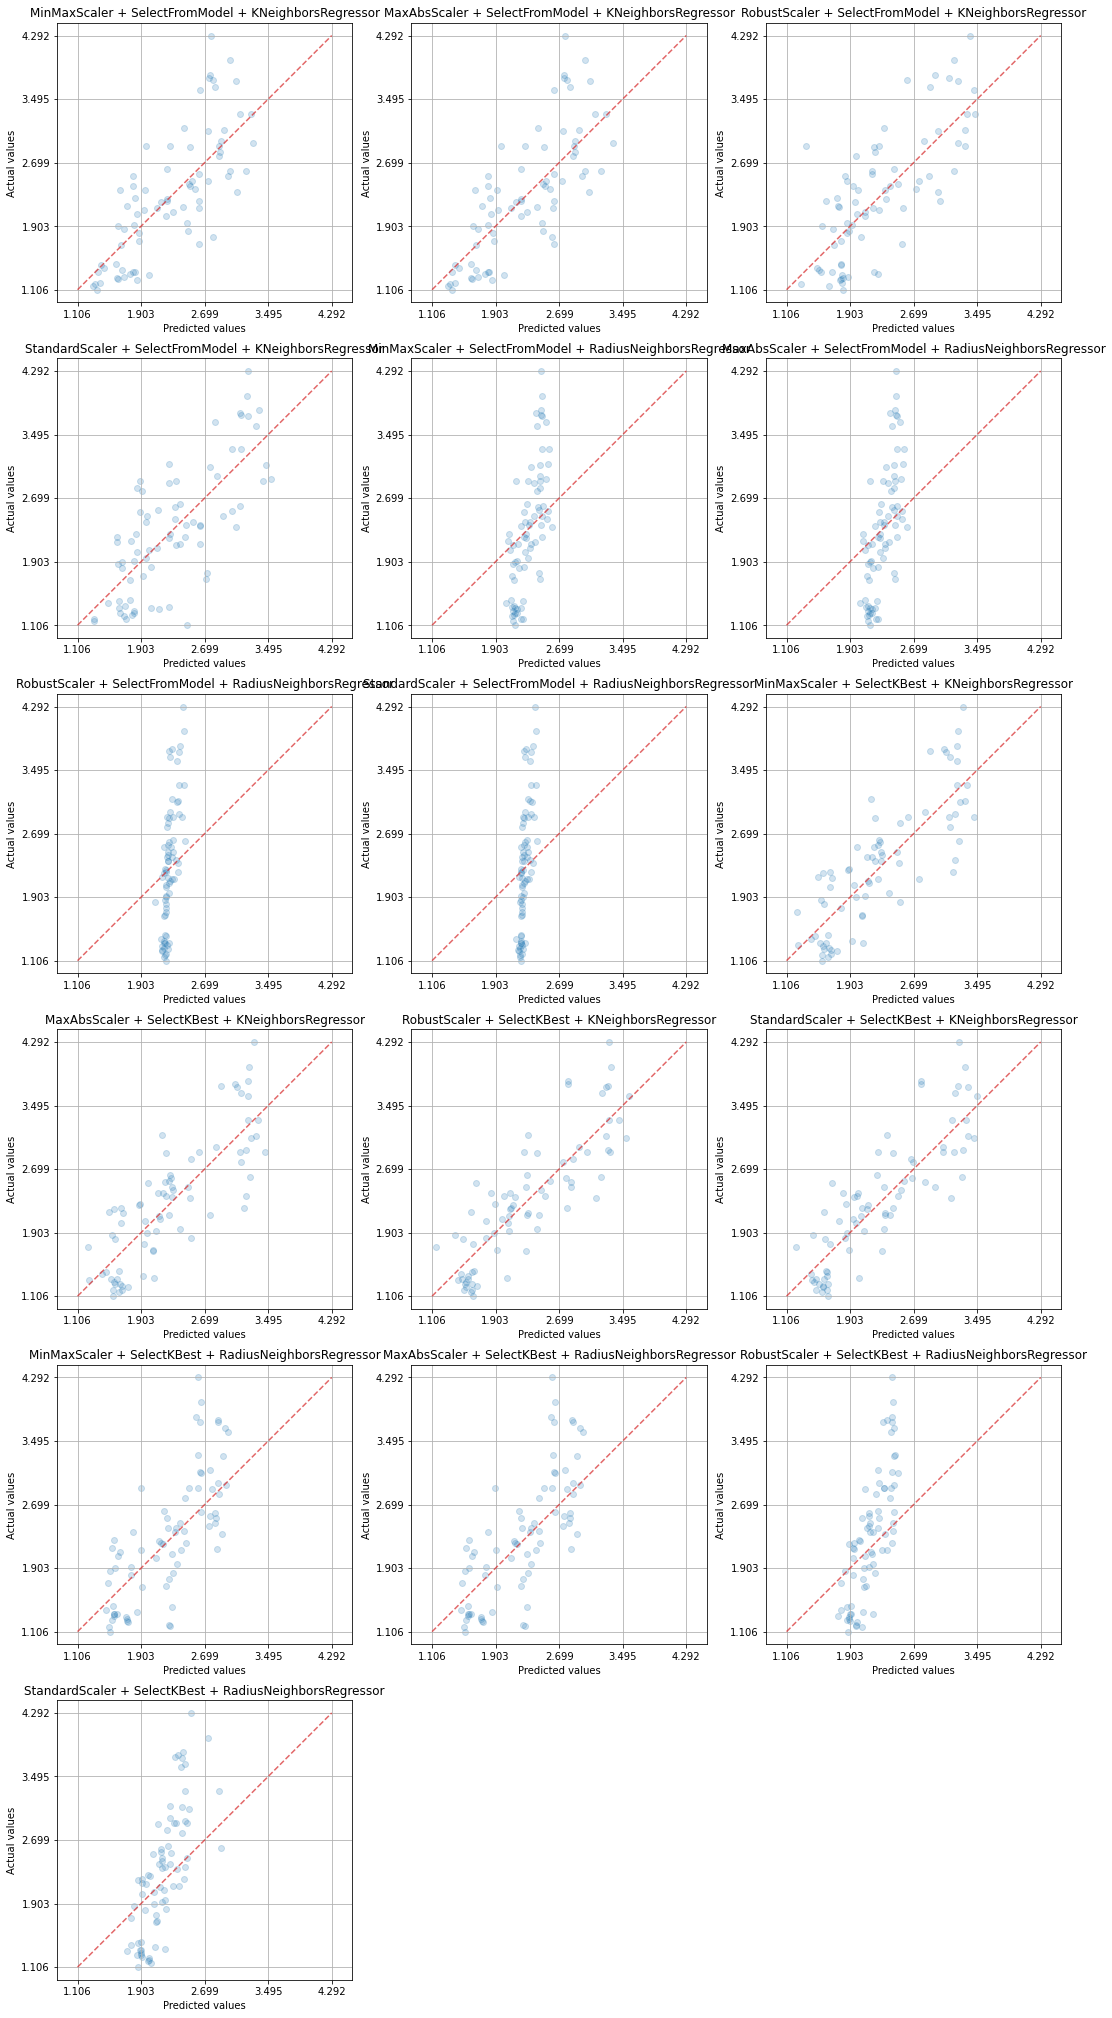

In [58]:
import numpy as np
from sklearn.model_selection import cross_validate, ShuffleSplit, GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

results = pd.DataFrame(columns=['Model', 'R2', 'MAE', 'MAPE', 'MSE', 'params'])
cv_scorings = ['r2', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']

x_train, x_test, y_train, y_test = \
    train_test_stratified_split(x_all, y_all,
                                test_size = 0.20, random_state = 0)

for i_category, item in enumerate(models.items()):
    #create_header(item[0])
    fig, ax = create_containing_plot(i_category, len(item[1]))
    for i_m, model in enumerate(item[1]):
        splitter = custom_cv_stratified_regression(5, x_train, y_train, 
                                                   test_size = 0.20, random_state = 0)
        
        logger.info(f'Processing model {model.name} ...')
        estimator, performanceMetrics, best_params = \
            get_fit_estimator(model.instance, x_train, y_train, splitter, cv_scorings) \
                if model.params_tuning is None else \
            get_fit_estimator_with_tuning(model.instance, model.params_tuning, 
                                          x_train, y_train, splitter, cv_scorings)
            
        logger.info(f'model {model.name} is ready')

        y_predictions = estimator.predict(x_test)

        results = pd.concat([results, pd.DataFrame([
            { 
                'Model': model.name, 
                'R2': performanceMetrics.r2, 
                'MAE': performanceMetrics.mae, 
                'MAPE': performanceMetrics.mape,
                'MSE': performanceMetrics.mse,
                'params': best_params
            }
            ])])
        fill_predictions_subplot(ax, i_m, model.name, y_test, y_predictions)

results.sort_values(by='MAE', ascending=False)